# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [3]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 1000
lr = 0.5e-4
batch_size = 10
num_workers = 1

### Create Model

In [5]:
model = resnet18()

inplanes 36  planes 36
inplanes 36  planes 36
inplanes 36  planes 72
inplanes 72  planes 72
inplanes 72  planes 144
inplanes 144  planes 144
inplanes 144  planes 288
inplanes 288  planes 288


### Handle GPU

In [6]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:3')
    model = model.to(device)
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:3 dtype <class 'torch.cuda.FloatTensor'>


### Handle loss function and optimizer

In [7]:
crit = torch.nn.CrossEntropyLoss()
opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

### Track stats

In [8]:
stats = np.zeros(shape=(num_epoch, 2, 2))

# indices
train = 0
test  = 1
acc   = 0
loss  = 1


### Load data

In [9]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [10]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [11]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [12]:
train_ds = har_dataset(train_data, train_labels)
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers)
train_batches = train_dl.__len__()

test_ds = har_dataset(test_data, test_labels)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
test_batches = test_dl.__len__()

### Train !

In [13]:
tstart = time.time()
for epoch in range(num_epoch):
    
    # switch to train mode
    model.train()
    
    # track accuracy
    total = 0
    correct = 0
    
    # track loss
    tr_loss = []
    for batch, data in enumerate(train_dl):
        print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')
        
        # extract signal and labels
        signals, labels = data
        
        ## Normalize?
        
        # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
        signals = signals.transpose(1,2)
        
        # move data to device
        signals = signals.to(device)
        labels = labels.type(ltype).to(device)
        
        # process signals
        out = model(signals)
        
        # hard decision for classification
        _, pred = torch.max(out.data, 1)
        
#         print(pred)
#         print(labels)
#         print()
        
        # compute accuracy
        total   += labels.size(0)
        correct += (pred == labels).sum().item()
        
        # compute loss
        b_loss = crit(out, labels)
        opt.zero_grad()
        b_loss.backward()
        opt.step()
        
        tr_loss.append(b_loss.item())
    
    # epoch training stats
    tr_accuracy = 100. * correct / total
    tr_loss = np.mean(tr_loss)
    
    # evaluate model
    model.eval()
    
    ts_loss = []
    total   = 0
    correct = 0
    with torch.no_grad():
        for batch, data in enumerate(test_dl):
            print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')
            
            # extract signals and labels
            signals, labels = data
            
            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)
            
            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)
            
            # process signals
            out = model(signals)
            
            # hard decision for classification
            _, pred = torch.max(out.data, 1)
            
            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()
            
            # compute loss
            b_loss = crit(out, labels)
            
            ts_loss.append(b_loss.item())
            
    # epoch testing stats
    ts_accuracy = 100. * correct / total
    ts_loss = np.mean(ts_loss)
    
    # save stats to plot later
    stats[epoch, train, loss ] = tr_loss
    stats[epoch, train, acc  ] = tr_accuracy
    stats[epoch, test,  loss ] = ts_loss
    stats[epoch, test,  acc  ] = ts_accuracy
    
    t1 = time.time() - tstart
    print('Epoch: {0:4d} Tr loss: {1:.6f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s'.format(
            epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1))

Epoch:    1 Tr loss: 1.036 Ts loss: 0.660 Tr Accuracy: 76.83% Ts Accuracy: 76.83% Time: 7.31s
Epoch:    2 Tr loss: 0.262 Ts loss: 0.535 Tr Accuracy: 81.82% Ts Accuracy: 81.82% Time: 9.89s
Epoch:    3 Tr loss: 0.099 Ts loss: 0.508 Tr Accuracy: 81.82% Ts Accuracy: 81.82% Time: 12.87s
Epoch:    4 Tr loss: 0.046 Ts loss: 0.607 Tr Accuracy: 80.35% Ts Accuracy: 80.35% Time: 15.90s
Epoch:    5 Tr loss: 0.026 Ts loss: 0.655 Tr Accuracy: 81.23% Ts Accuracy: 81.23% Time: 18.84s
Epoch:    6 Tr loss: 0.017 Ts loss: 0.560 Tr Accuracy: 83.87% Ts Accuracy: 83.87% Time: 21.95s
Epoch:    7 Tr loss: 0.011 Ts loss: 0.582 Tr Accuracy: 83.58% Ts Accuracy: 83.58% Time: 24.95s
Epoch:    8 Tr loss: 0.008 Ts loss: 0.570 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 27.63s
Epoch:    9 Tr loss: 0.006 Ts loss: 0.542 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 30.56s
Epoch:   10 Tr loss: 0.005 Ts loss: 0.559 Tr Accuracy: 84.16% Ts Accuracy: 84.16% Time: 33.36s
Epoch:   11 Tr loss: 0.004 Ts loss: 0.571 Tr Accurac

Epoch:   87 Tr loss: 0.000 Ts loss: 0.900 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 241.33s
Epoch:   88 Tr loss: 0.000 Ts loss: 0.903 Tr Accuracy: 84.75% Ts Accuracy: 84.75% Time: 243.82s
Epoch:   89 Tr loss: 0.000 Ts loss: 0.907 Tr Accuracy: 84.75% Ts Accuracy: 84.75% Time: 246.48s
Epoch:   90 Tr loss: 0.000 Ts loss: 0.910 Tr Accuracy: 84.75% Ts Accuracy: 84.75% Time: 249.02s
Epoch:   91 Tr loss: 0.000 Ts loss: 0.914 Tr Accuracy: 84.75% Ts Accuracy: 84.75% Time: 251.68s
Epoch:   92 Tr loss: 0.000 Ts loss: 0.917 Tr Accuracy: 84.75% Ts Accuracy: 84.75% Time: 254.58s
Epoch:   93 Tr loss: 0.000 Ts loss: 0.921 Tr Accuracy: 84.75% Ts Accuracy: 84.75% Time: 257.54s
Epoch:   94 Tr loss: 0.000 Ts loss: 0.925 Tr Accuracy: 84.75% Ts Accuracy: 84.75% Time: 260.36s
Epoch:   95 Tr loss: 0.000 Ts loss: 0.928 Tr Accuracy: 84.75% Ts Accuracy: 84.75% Time: 263.04s
Epoch:   96 Tr loss: 0.000 Ts loss: 0.931 Tr Accuracy: 84.75% Ts Accuracy: 84.75% Time: 266.29s
Epoch:   97 Tr loss: 0.000 Ts loss: 0.93

Epoch:  172 Tr loss: 0.000 Ts loss: 1.122 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 477.21s
Epoch:  173 Tr loss: 0.000 Ts loss: 1.121 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 479.89s
Epoch:  174 Tr loss: 0.000 Ts loss: 1.128 Tr Accuracy: 84.16% Ts Accuracy: 84.16% Time: 482.55s
Epoch:  175 Tr loss: 0.000 Ts loss: 1.125 Tr Accuracy: 84.16% Ts Accuracy: 84.16% Time: 485.40s
Epoch:  176 Tr loss: 0.000 Ts loss: 1.115 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 487.94s
Epoch:  177 Tr loss: 0.000 Ts loss: 1.120 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 490.67s
Epoch:  178 Tr loss: 0.000 Ts loss: 1.118 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 493.63s
Epoch:  179 Tr loss: 0.000 Ts loss: 1.118 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 496.65s
Epoch:  180 Tr loss: 0.000 Ts loss: 1.113 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 499.67s
Epoch:  181 Tr loss: 0.000 Ts loss: 1.113 Tr Accuracy: 84.46% Ts Accuracy: 84.46% Time: 502.15s
Epoch:  182 Tr loss: 0.000 Ts loss: 1.11

Epoch:  257 Tr loss: 0.000 Ts loss: 0.604 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 711.21s
Epoch:  258 Tr loss: 0.000 Ts loss: 0.607 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 714.13s
Epoch:  259 Tr loss: 0.000 Ts loss: 0.610 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 717.07s
Epoch:  260 Tr loss: 0.000 Ts loss: 0.612 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 719.96s
Epoch:  261 Tr loss: 0.000 Ts loss: 0.615 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 722.95s
Epoch:  262 Tr loss: 0.000 Ts loss: 0.618 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 725.78s
Epoch:  263 Tr loss: 0.000 Ts loss: 0.620 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 728.81s
Epoch:  264 Tr loss: 0.000 Ts loss: 0.623 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 731.77s
Epoch:  265 Tr loss: 0.000 Ts loss: 0.625 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 734.59s
Epoch:  266 Tr loss: 0.000 Ts loss: 0.628 Tr Accuracy: 87.68% Ts Accuracy: 87.68% Time: 737.14s
Epoch:  267 Tr loss: 0.000 Ts loss: 0.63

Epoch:  342 Tr loss: 0.000 Ts loss: 0.773 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 943.80s
Epoch:  343 Tr loss: 0.000 Ts loss: 0.775 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 946.61s
Epoch:  344 Tr loss: 0.000 Ts loss: 0.776 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 949.36s
Epoch:  345 Tr loss: 0.000 Ts loss: 0.778 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 952.21s
Epoch:  346 Tr loss: 0.000 Ts loss: 0.780 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 955.27s
Epoch:  347 Tr loss: 0.000 Ts loss: 0.781 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 957.79s
Epoch:  348 Tr loss: 0.000 Ts loss: 0.783 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 960.78s
Epoch:  349 Tr loss: 0.000 Ts loss: 0.785 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 963.54s
Epoch:  350 Tr loss: 0.000 Ts loss: 0.786 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 966.36s
Epoch:  351 Tr loss: 0.000 Ts loss: 0.789 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 969.29s
Epoch:  352 Tr loss: 0.000 Ts loss: 0.79

Epoch:  427 Tr loss: 0.000 Ts loss: 0.972 Tr Accuracy: 86.80% Ts Accuracy: 86.80% Time: 1177.71s
Epoch:  428 Tr loss: 0.000 Ts loss: 0.958 Tr Accuracy: 86.80% Ts Accuracy: 86.80% Time: 1180.32s
Epoch:  429 Tr loss: 0.000 Ts loss: 0.966 Tr Accuracy: 86.22% Ts Accuracy: 86.22% Time: 1183.41s
Epoch:  430 Tr loss: 0.000 Ts loss: 0.917 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 1186.46s
Epoch:  431 Tr loss: 0.167 Ts loss: 0.556 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 1189.19s
Epoch:  432 Tr loss: 0.099 Ts loss: 0.629 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 1191.77s
Epoch:  433 Tr loss: 0.027 Ts loss: 0.729 Tr Accuracy: 86.80% Ts Accuracy: 86.80% Time: 1194.29s
Epoch:  434 Tr loss: 0.006 Ts loss: 0.685 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 1197.34s
Epoch:  435 Tr loss: 0.004 Ts loss: 0.827 Tr Accuracy: 86.51% Ts Accuracy: 86.51% Time: 1199.58s
Epoch:  436 Tr loss: 0.003 Ts loss: 0.695 Tr Accuracy: 87.39% Ts Accuracy: 87.39% Time: 1202.11s
Epoch:  437 Tr loss: 0.001 Ts 

Epoch:  512 Tr loss: 0.000 Ts loss: 0.761 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1408.10s
Epoch:  513 Tr loss: 0.000 Ts loss: 0.763 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1410.61s
Epoch:  514 Tr loss: 0.000 Ts loss: 0.765 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1413.18s
Epoch:  515 Tr loss: 0.000 Ts loss: 0.767 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1415.73s
Epoch:  516 Tr loss: 0.000 Ts loss: 0.769 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1418.57s
Epoch:  517 Tr loss: 0.000 Ts loss: 0.770 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1420.90s
Epoch:  518 Tr loss: 0.000 Ts loss: 0.772 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1423.42s
Epoch:  519 Tr loss: 0.000 Ts loss: 0.774 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1425.77s
Epoch:  520 Tr loss: 0.000 Ts loss: 0.776 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1428.08s
Epoch:  521 Tr loss: 0.000 Ts loss: 0.777 Tr Accuracy: 89.15% Ts Accuracy: 89.15% Time: 1430.70s
Epoch:  522 Tr loss: 0.000 Ts 

Epoch:  597 Tr loss: 0.000 Ts loss: 0.959 Tr Accuracy: 87.39% Ts Accuracy: 87.39% Time: 1637.86s
Epoch:  598 Tr loss: 0.000 Ts loss: 0.964 Tr Accuracy: 87.68% Ts Accuracy: 87.68% Time: 1640.55s
Epoch:  599 Tr loss: 0.000 Ts loss: 0.968 Tr Accuracy: 87.98% Ts Accuracy: 87.98% Time: 1643.51s
Epoch:  600 Tr loss: 0.000 Ts loss: 0.973 Tr Accuracy: 87.68% Ts Accuracy: 87.68% Time: 1646.14s
Epoch:  601 Tr loss: 0.000 Ts loss: 0.985 Tr Accuracy: 87.39% Ts Accuracy: 87.39% Time: 1648.67s
Epoch:  602 Tr loss: 0.000 Ts loss: 0.988 Tr Accuracy: 87.68% Ts Accuracy: 87.68% Time: 1651.81s
Epoch:  603 Tr loss: 0.000 Ts loss: 0.990 Tr Accuracy: 87.68% Ts Accuracy: 87.68% Time: 1654.45s
Epoch:  604 Tr loss: 0.000 Ts loss: 1.005 Tr Accuracy: 87.68% Ts Accuracy: 87.68% Time: 1657.14s
Epoch:  605 Tr loss: 0.000 Ts loss: 1.006 Tr Accuracy: 87.39% Ts Accuracy: 87.39% Time: 1659.89s
Epoch:  606 Tr loss: 0.000 Ts loss: 1.007 Tr Accuracy: 87.39% Ts Accuracy: 87.39% Time: 1662.65s
Epoch:  607 Tr loss: 0.000 Ts 

Epoch:  682 Tr loss: 0.000 Ts loss: 0.625 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 1872.40s
Epoch:  683 Tr loss: 0.000 Ts loss: 0.627 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 1875.06s
Epoch:  684 Tr loss: 0.000 Ts loss: 0.629 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 1877.99s
Epoch:  685 Tr loss: 0.000 Ts loss: 0.631 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 1880.62s
Epoch:  686 Tr loss: 0.000 Ts loss: 0.633 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 1883.23s
Epoch:  687 Tr loss: 0.000 Ts loss: 0.635 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 1885.67s
Epoch:  688 Tr loss: 0.000 Ts loss: 0.633 Tr Accuracy: 90.62% Ts Accuracy: 90.62% Time: 1888.57s
Epoch:  689 Tr loss: 0.000 Ts loss: 0.635 Tr Accuracy: 90.62% Ts Accuracy: 90.62% Time: 1891.20s
Epoch:  690 Tr loss: 0.000 Ts loss: 0.637 Tr Accuracy: 90.62% Ts Accuracy: 90.62% Time: 1893.91s
Epoch:  691 Tr loss: 0.000 Ts loss: 0.639 Tr Accuracy: 90.62% Ts Accuracy: 90.62% Time: 1897.00s
Epoch:  692 Tr loss: 0.000 Ts 

Epoch:  767 Tr loss: 0.000 Ts loss: 0.792 Tr Accuracy: 90.03% Ts Accuracy: 90.03% Time: 2104.62s
Epoch:  768 Tr loss: 0.000 Ts loss: 0.795 Tr Accuracy: 90.03% Ts Accuracy: 90.03% Time: 2107.59s
Epoch:  769 Tr loss: 0.000 Ts loss: 0.798 Tr Accuracy: 90.03% Ts Accuracy: 90.03% Time: 2110.46s
Epoch:  770 Tr loss: 0.000 Ts loss: 0.802 Tr Accuracy: 90.03% Ts Accuracy: 90.03% Time: 2113.16s
Epoch:  771 Tr loss: 0.000 Ts loss: 0.798 Tr Accuracy: 90.32% Ts Accuracy: 90.32% Time: 2115.82s
Epoch:  772 Tr loss: 0.000 Ts loss: 0.802 Tr Accuracy: 90.03% Ts Accuracy: 90.03% Time: 2118.55s
Epoch:  773 Tr loss: 0.000 Ts loss: 0.806 Tr Accuracy: 90.03% Ts Accuracy: 90.03% Time: 2120.95s
Epoch:  774 Tr loss: 0.000 Ts loss: 0.810 Tr Accuracy: 90.03% Ts Accuracy: 90.03% Time: 2123.57s
Epoch:  775 Tr loss: 0.000 Ts loss: 0.813 Tr Accuracy: 90.03% Ts Accuracy: 90.03% Time: 2126.53s
Epoch:  776 Tr loss: 0.000 Ts loss: 0.817 Tr Accuracy: 90.03% Ts Accuracy: 90.03% Time: 2129.62s
Epoch:  777 Tr loss: 0.000 Ts 

Epoch:  852 Tr loss: 0.000 Ts loss: 0.823 Tr Accuracy: 91.20% Ts Accuracy: 91.20% Time: 2339.86s
Epoch:  853 Tr loss: 0.000 Ts loss: 0.824 Tr Accuracy: 91.20% Ts Accuracy: 91.20% Time: 2342.88s
Epoch:  854 Tr loss: 0.000 Ts loss: 0.824 Tr Accuracy: 91.50% Ts Accuracy: 91.50% Time: 2345.58s
Epoch:  855 Tr loss: 0.000 Ts loss: 0.825 Tr Accuracy: 91.50% Ts Accuracy: 91.50% Time: 2348.24s
Epoch:  856 Tr loss: 0.000 Ts loss: 0.825 Tr Accuracy: 91.50% Ts Accuracy: 91.50% Time: 2350.83s
Epoch:  857 Tr loss: 0.000 Ts loss: 0.826 Tr Accuracy: 91.50% Ts Accuracy: 91.50% Time: 2353.63s
Epoch:  858 Tr loss: 0.000 Ts loss: 0.826 Tr Accuracy: 91.50% Ts Accuracy: 91.50% Time: 2356.26s
Epoch:  859 Tr loss: 0.000 Ts loss: 0.827 Tr Accuracy: 91.50% Ts Accuracy: 91.50% Time: 2359.03s
Epoch:  860 Tr loss: 0.000 Ts loss: 0.827 Tr Accuracy: 91.50% Ts Accuracy: 91.50% Time: 2361.85s
Epoch:  861 Tr loss: 0.000 Ts loss: 0.828 Tr Accuracy: 91.50% Ts Accuracy: 91.50% Time: 2364.75s
Epoch:  862 Tr loss: 0.000 Ts 

Epoch:  937 Tr loss: 0.000 Ts loss: 0.902 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2576.16s
Epoch:  938 Tr loss: 0.000 Ts loss: 0.903 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2578.84s
Epoch:  939 Tr loss: 0.000 Ts loss: 0.904 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2581.63s
Epoch:  940 Tr loss: 0.000 Ts loss: 0.905 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2584.54s
Epoch:  941 Tr loss: 0.000 Ts loss: 0.906 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2587.06s
Epoch:  942 Tr loss: 0.000 Ts loss: 0.907 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2589.66s
Epoch:  943 Tr loss: 0.000 Ts loss: 0.909 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2592.33s
Epoch:  944 Tr loss: 0.000 Ts loss: 0.910 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2595.17s
Epoch:  945 Tr loss: 0.000 Ts loss: 0.912 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2597.68s
Epoch:  946 Tr loss: 0.000 Ts loss: 0.914 Tr Accuracy: 90.91% Ts Accuracy: 90.91% Time: 2600.03s
Epoch:  947 Tr loss: 0.000 Ts 

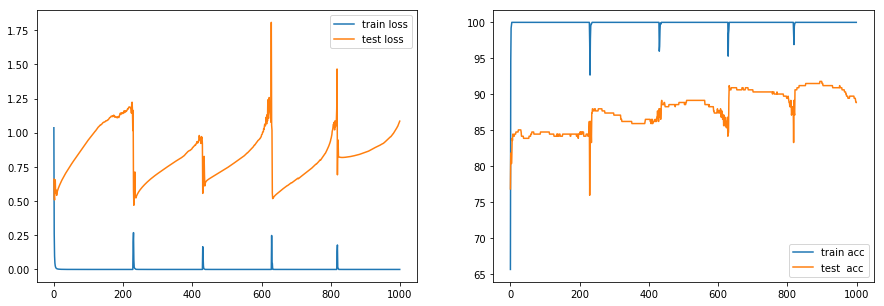

In [21]:
x = np.linspace(0,epoch,epoch+1)

tr_loss = stats[:,train,loss]
ts_loss = stats[:,test, loss]

tr_acc = stats[:, train, acc]
ts_acc = stats[:, test,  acc]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x,tr_loss,label='train loss')
plt.plot(x,ts_loss,label='test loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,tr_acc,label='train acc')
plt.plot(x,ts_acc,label='test  acc')
plt.legend()

plt.show()